In [17]:
import os
import re
import pandas as pd
from tqdm import tqdm


def preprocess_legal_text(text):
    """Clean and normalize legal text."""
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove line numbers or article numbers like "1.1", "Section 2", etc. (optional)
    text = re.sub(
        r'\b(Section|Article)?\s?\d+(\.\d+)*[:.)]?\s+', '', text, flags=re.IGNORECASE)

    # Normalize special unicode quotes and dashes
    text = text.replace('“', '"').replace(
        '”', '"').replace('–', '-').replace('—', '-')

    # Remove page headers/footers if repeating
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]

    return ' '.join(lines).strip()


def load_documents_from_text_folder(base_dir):
    """
    Load and preprocess text files from subfolders in base_dir. 
    Each subfolder is a document category.
    
    Returns a DataFrame with columns: id, name, category, text, file_path
    """
    documents = []
    doc_id = 0

    print(f"Loading documents from: {base_dir}\n")

    for category in sorted(os.listdir(base_dir)):
        category_path = os.path.join(base_dir, category)
        if not os.path.isdir(category_path):
            continue

        category_doc_count = 0

        for fname in os.listdir(category_path):
            if not fname.endswith(".txt"):
                continue

            file_path = os.path.join(category_path, fname)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    raw_text = f.read()
                    cleaned_text = preprocess_legal_text(raw_text)

                    if len(cleaned_text.split()) < 50:
                        print(f"Skipping too-short file: {fname}")
                        continue

                    documents.append({
                        'id': doc_id,
                        'name': os.path.splitext(fname)[0],
                        'category': category,
                        'text': cleaned_text,
                        'file_path': file_path
                    })
                    doc_id += 1
                    category_doc_count += 1

            except Exception as e:
                print(f" Error reading {file_path}: {e}")

        print(
            f" Loaded {category_doc_count} documents from category: {category}")

    docs_df = pd.DataFrame(documents)
    print(
        f"\n Total Documents Loaded: {len(docs_df)} across {docs_df['category'].nunique()} categories.")
    return docs_df

In [32]:
base_dir = "d:/PROJECTS/CLIENT/USA-Graph-ML/REPOS/Document_Fetch/doc_query_app/raw_files/chunk_input"
docs_df = load_documents_from_text_folder(base_dir)

Loading documents from: d:/PROJECTS/CLIENT/USA-Graph-ML/REPOS/Document_Fetch/doc_query_app/raw_files/chunk_input

 Loaded 33 documents from category: License_Agreements
 Loaded 34 documents from category: Maintenance
 Loaded 28 documents from category: Service
 Loaded 31 documents from category: Sponsorship
 Loaded 32 documents from category: Strategic Alliance

 Total Documents Loaded: 158 across 5 categories.


In [ ]:
import re
import pandas as pd
from tqdm import tqdm


def optimized_hybrid_chunking(docs_df, semantic_min_size=150, semantic_max_size=400,
                              hierarchical_levels=[400, 800], position_importance=True):
    """
    Optimized hybrid chunking combining semantic boundaries with hierarchical representation
    for both search and graph neural network applications.
    """
    chunks = []
    chunk_id_counter = 0  # Use a single counter

    section_patterns = [
        r'(?i)(?:\n|\s{2,})(?:section|article)\s+\d+[\.\:]\s+[A-Z]',
        r'\n[A-Z][A-Z\s]+(?:\n|\s{2,})',
        r'(?:\n|\s{2,})(?:\d+\.\d+|\d+\.)\s+[A-Z]',
        r'(?i)(?:\n|\s{2,})(?:DEFINITIONS|DEFINED TERMS)(?:\n|\s{2,})',
        r'(?:\n|\s{2,})(?:WHEREAS:|IN WITNESS WHEREOF:|NOW, THEREFORE,)',
        r'(?i)(?:\n|\s{2,})(?:RECITALS|WITNESSETH|APPENDIX|EXHIBIT|SCHEDULE|ANNEX)\s+[A-Za-z0-9]'
    ]
    compiled_patterns = [re.compile(pattern) for pattern in section_patterns]

    for _, doc in tqdm(docs_df.iterrows(), total=len(docs_df), desc="Creating hybrid chunks"):
        doc_id_val = doc['id']
        text = doc['text']

        # Create word to character offset mapping for the current document
        doc_text_words = text.split()  # Based on how preprocess_legal_text works
        char_start_offsets_for_words = [0] * len(doc_text_words)
        current_char_offset = 0
        # This simple split & find might be fragile if text has complex whitespace.
        # preprocess_legal_text aims to normalize this.
        temp_text_for_offsets = text
        for i, word in enumerate(doc_text_words):
            try:
                word_pos = temp_text_for_offsets.find(word)
                char_start_offsets_for_words[i] = current_char_offset + word_pos
                advance_offset = word_pos + len(word)
                current_char_offset += advance_offset
                temp_text_for_offsets = temp_text_for_offsets[advance_offset:]
            except Exception:  # Fallback if find fails unexpectedly
                if i > 0:
                     char_start_offsets_for_words[i] = char_start_offsets_for_words[i-1] + len(
                         doc_text_words[i-1]) + 1
                else:
                     char_start_offsets_for_words[i] = 0

        doc_chunks_meta_l1 = []  # Store L1 chunk metadata for this doc

        # STEP 1: Create semantic boundaries
        boundaries = [0]
        for pattern in compiled_patterns:
            for match in pattern.finditer(text):
                boundaries.append(match.start())
        paragraph_breaks = [m.start() for m in re.finditer(r'\n\s*\n', text)]
        boundaries.extend(paragraph_breaks)
        boundaries.append(len(text))
        boundaries = sorted(list(set(boundaries)))

        # STEP 2: Create initial semantic_chunks (L1 precursor)
        raw_semantic_chunks = []
        special_sections = {'definitions': None, 'termination': None,
                            'confidentiality': None, 'indemnification': None}

        for i in range(len(boundaries) - 1):
            chunk_text = text[boundaries[i]:boundaries[i+1]].strip()
            if not chunk_text:
                continue

            lower_text = chunk_text.lower()
            for section_type_key in special_sections:
                # Arbitrary length
                if section_type_key in lower_text and len(chunk_text.split()) > 20:
                    # Mark first occurrence
                    if special_sections[section_type_key] is None:
                       special_sections[section_type_key] = len(
                           raw_semantic_chunks)

            total_initial_chunks = len(boundaries) - 1
            position_val = "middle"
            position_score_val = 0.8 if position_importance else 0.7
            if total_initial_chunks > 0:  # Avoid division by zero
                if i < total_initial_chunks * 0.2:
                    position_val = "beginning"
                    position_score_val = 0.95 if position_importance else 0.7
                elif i > total_initial_chunks * 0.8:
                    position_val = "end"
                    position_score_val = 0.7 if position_importance else 0.7

            raw_semantic_chunks.append({
                'text': chunk_text, 'start_idx': boundaries[i], 'end_idx': boundaries[i+1],
                'position': position_val, 'position_score': position_score_val, 'original_idx': i
            })

        # STEP 3: Process L1 chunk sizes
        processed_l1_chunks = []
        idx_raw_sem = 0
        while idx_raw_sem < len(raw_semantic_chunks):
            chunk = raw_semantic_chunks[idx_raw_sem]
            words = chunk['text'].split()

            if len(words) < semantic_min_size and idx_raw_sem < len(raw_semantic_chunks) - 1:
                next_chunk = raw_semantic_chunks[idx_raw_sem + 1]
                combined_text = chunk['text'] + " " + \
                    next_chunk['text']  # Simple space join
                if len(combined_text.split()) <= semantic_max_size:
                    # Merge chunk with next_chunk
                    raw_semantic_chunks[idx_raw_sem +
                                        1]['text'] = combined_text
                    raw_semantic_chunks[idx_raw_sem +
                                        1]['start_idx'] = chunk['start_idx']
                    # Position/score of the merged chunk could be re-evaluated or taken from the first.
                    # For simplicity, next_chunk's original position info is largely kept, but start_idx is updated.
                    idx_raw_sem += 1  # Skip current chunk as it's merged into next
                    continue

            if len(words) > semantic_max_size:
                # Try natural sub-divisions first
                sub_texts_natural = re.split(r'\n\s*\n', chunk['text'])
                if len(sub_texts_natural) > 1 and all(len(t.split()) < semantic_max_size for t in sub_texts_natural if t.strip()):
                    current_char_offset_in_chunk = 0
                    for sub_idx, sub_text_natural in enumerate(sub_texts_natural):
                        sub_text_natural = sub_text_natural.strip()
                        if not sub_text_natural:
                            continue

                        sub_pos = chunk['position']
                        sub_score = chunk['position_score']
                        if sub_idx > 0:
                            sub_score = max(
                                0.6, chunk['position_score'] - 0.1 * sub_idx)

                        processed_l1_chunks.append({
                            'text': sub_text_natural,
                            'start_idx': chunk['start_idx'] + current_char_offset_in_chunk,
                            'end_idx': chunk['start_idx'] + current_char_offset_in_chunk + len(sub_text_natural),
                            'position': sub_pos, 'position_score': sub_score,
                            'parent_original_idx': chunk.get('original_idx', -1)
                        })
                        current_char_offset_in_chunk += len(sub_text_natural) + (len(
                            chunk['text']) - current_char_offset_in_chunk - len(sub_text_natural) > 0)  # Approx for separator
                else:  # Forced splits
                    current_word_idx_in_chunk = 0
                    # Words of the current large L1 chunk
                    chunk_words = chunk['text'].split()

                    # Create char offsets for words within this specific chunk['text']
                    offsets_in_chunk_text = [0] * len(chunk_words)
                    temp_chunk_text_ptr = 0
                    search_text_segment = chunk['text']
                    for i_cw, cw in enumerate(chunk_words):
                        try:
                            pos_cw = search_text_segment.find(cw)
                            offsets_in_chunk_text[i_cw] = temp_chunk_text_ptr + pos_cw
                            adv = pos_cw + len(cw)
                            temp_chunk_text_ptr += adv
                            search_text_segment = search_text_segment[adv:]
                        except:  # Fallback
                            if i_cw > 0:
                                offsets_in_chunk_text[i_cw] = offsets_in_chunk_text[i_cw-1] + len(
                                    chunk_words[i_cw-1]) + 1
                            else:
                                offsets_in_chunk_text[i_cw] = 0

                    while current_word_idx_in_chunk < len(chunk_words):
                        sub_chunk_words = chunk_words[current_word_idx_in_chunk:
                            current_word_idx_in_chunk + semantic_max_size]
                        if not sub_chunk_words:
                            break

                        # Reconstruct with single spaces
                        sub_text_forced = " ".join(sub_chunk_words)

                        # Determine char start/end for this sub_text_forced within original document
                        sub_chunk_char_start_in_chunktext = offsets_in_chunk_text[
                            current_word_idx_in_chunk]

                        # End is start of last word + len of last word
                        idx_of_last_word_in_sub_chunk = current_word_idx_in_chunk + \
                            len(sub_chunk_words) - 1
                        sub_chunk_char_end_in_chunktext = offsets_in_chunk_text[idx_of_last_word_in_sub_chunk] + len(
                            chunk_words[idx_of_last_word_in_sub_chunk])

                        sub_pos = chunk['position']
                        sub_score = chunk['position_score']
                        if current_word_idx_in_chunk > 0:
                            sub_score = max(0.6, chunk['position_score'] - 0.1)

                        processed_l1_chunks.append({
                            'text': sub_text_forced,
                            'start_idx': chunk['start_idx'] + sub_chunk_char_start_in_chunktext,
                            'end_idx': chunk['start_idx'] + sub_chunk_char_end_in_chunktext,
                            'position': sub_pos, 'position_score': sub_score,
                            'parent_original_idx': chunk.get('original_idx', -1)
                        })
                        current_word_idx_in_chunk += len(sub_chunk_words)
            else:  # Chunk size is acceptable
                processed_l1_chunks.append(chunk)
            idx_raw_sem += 1

        # STEP 4: Create final L1 chunks and then hierarchical chunks (L2+)
        doc_all_level_chunks = []

        # Add L1 (semantic) chunks
        for l1_chunk_data in processed_l1_chunks:
            is_special = False
            special_type_name = None
            parent_orig_idx = l1_chunk_data.get(
                'parent_original_idx', l1_chunk_data.get('original_idx'))

            for sec_type, orig_idx in special_sections.items():
                if orig_idx is not None and parent_orig_idx == orig_idx:
                    is_special = True
                    special_type_name = sec_type
                    break

            current_chunk_id = chunk_id_counter
            final_l1_chunk = {
                'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                'category': doc['category'], 'text': l1_chunk_data['text'],
                'chunk_method': 'semantic', 'level': 'L1',
                'start_idx': l1_chunk_data['start_idx'], 'end_idx': l1_chunk_data['end_idx'],
                'document_position': l1_chunk_data['position'], 'position_score': l1_chunk_data['position_score'],
                'is_special_section': is_special
            }
            if is_special:
                final_l1_chunk['section_type'] = special_type_name

            doc_all_level_chunks.append(final_l1_chunk)
            doc_chunks_meta_l1.append({  # For L2+ contained_chunks logic
                'chunk_id': current_chunk_id,
                'char_start_idx': l1_chunk_data['start_idx'],  # Char idx
                'char_end_idx': l1_chunk_data['end_idx']      # Char idx
            })
            chunk_id_counter += 1

        # Add L2+ (hierarchical) chunks
        for level_idx, hier_chunk_size_words in enumerate(hierarchical_levels):
            level_name = f"L{level_idx + 2}"
            if len(doc_text_words) < hier_chunk_size_words * 1.5:
                continue  # Skip if doc too short for this level

            overlap_words = min(hier_chunk_size_words // 4, 50)

            for i_word_hier in range(0, len(doc_text_words), hier_chunk_size_words - overlap_words):
                hier_sub_words = doc_text_words[i_word_hier: i_word_hier + \
                    hier_chunk_size_words]
                if len(hier_sub_words) < hier_chunk_size_words // 3:
                    continue

                hier_text = " ".join(hier_sub_words)

                # Hierarchical chunk boundaries in characters
                hier_char_start = char_start_offsets_for_words[i_word_hier]
                idx_last_word_in_hier = i_word_hier + len(hier_sub_words) - 1
                hier_char_end = char_start_offsets_for_words[idx_last_word_in_hier] + len(
                    doc_text_words[idx_last_word_in_hier]) if idx_last_word_in_hier < len(doc_text_words) else len(text)

                pos_hier = "middle"
                score_hier = 0.75 if position_importance else 0.7
                total_hier_chunks_at_level = max(1, (len(
                    doc_text_words) - hier_chunk_size_words) // (hier_chunk_size_words - overlap_words) + 1)
                current_hier_chunk_index = i_word_hier // (
                    hier_chunk_size_words-overlap_words)
                if total_hier_chunks_at_level > 0:
                    if current_hier_chunk_index < total_hier_chunks_at_level / 3:
                        pos_hier = "beginning"
                        score_hier = 0.85 if position_importance else 0.7
                    elif current_hier_chunk_index > 2 * total_hier_chunks_at_level / 3:
                        pos_hier = "end"
                        score_hier = 0.7 if position_importance else 0.7

                contained_l1_ids = []
                for l1_meta in doc_chunks_meta_l1:
                    # Check for overlap: max(start1, start2) < min(end1, end2)
                    if max(hier_char_start, l1_meta['char_start_idx']) < min(hier_char_end, l1_meta['char_end_idx']):
                        contained_l1_ids.append(l1_meta['chunk_id'])

                current_chunk_id = chunk_id_counter
                doc_all_level_chunks.append({
                    'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                    'category': doc['category'], 'text': hier_text,
                    'chunk_method': 'hierarchical', 'level': level_name, 'level_size': hier_chunk_size_words,
                    'start_idx': hier_char_start,  # Store char indices for consistency if preferred
                    # Or store word indices i_word_hier, i_word_hier + len(hier_sub_words)
                    'end_idx': hier_char_end,
                    'document_position': pos_hier, 'position_score': score_hier,
                    'contained_chunks': contained_l1_ids  # List of L1 chunk IDs
                })
                chunk_id_counter += 1

        # Full document chunk for small documents
        # Consider adjusting this threshold if you want to change how medium-sized documents are handled
        if len(doc_text_words) < 1000:  # Arbitrary threshold, potentially increase if desired
            current_chunk_id = chunk_id_counter
            doc_all_level_chunks.append({
                'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                'category': doc['category'], 'text': text,
                'chunk_method': 'full_document', 'level': 'full',
                'start_idx': 0, 'end_idx': len(text),
                'document_position': 'complete', 'position_score': 1.0,
                'contained_chunks': [m['chunk_id'] for m in doc_chunks_meta_l1]
            })
            chunk_id_counter += 1

        chunks.extend(doc_all_level_chunks)

    chunks_df = pd.DataFrame(chunks)

    if not chunks_df.empty:
        # Add chunk_relationships
        # This can be slow on very large dataframes.
        # Pre-calculating lookups or using groupby could optimize if needed.

        # Create a lookup for L1 chunks per document
        l1_chunks_by_doc = {}
        if 'level' in chunks_df.columns and 'doc_id' in chunks_df.columns and 'chunk_id' in chunks_df.columns:
            l1_chunks_by_doc = chunks_df[chunks_df['level'] == 'L1'].groupby(
                'doc_id')['chunk_id'].apply(list).to_dict()

        # Create a lookup for hierarchical parents
        # A L1 chunk's parents are L2+ chunks that contain it.
        hier_parents_lookup = {}  # Key: L1_chunk_id, Value: list of L2+_chunk_ids
        if 'contained_chunks' in chunks_df.columns and 'chunk_method' in chunks_df.columns:
            for _, row in chunks_df.iterrows():
                if row['chunk_method'] == 'hierarchical' or row['chunk_method'] == 'full_document':
                    if isinstance(row['contained_chunks'], list):
                        for l1_child_id in row['contained_chunks']:
                            if l1_child_id not in hier_parents_lookup:
                                hier_parents_lookup[l1_child_id] = []
                            hier_parents_lookup[l1_child_id].append(
                                row['chunk_id'])

        def get_relationships(row):
            rels = {'same_doc_l1_chunks': [], 'hierarchical_parents': []}
            if row['level'] == 'L1':  # Relationships primarily defined for L1 nodes
                # Same document L1 chunks (excluding self)
                rels['same_doc_l1_chunks'] = [cid for cid in l1_chunks_by_doc.get(
                    row['doc_id'], []) if cid != row['chunk_id']]
                # Hierarchical parents
                rels['hierarchical_parents'] = hier_parents_lookup.get(
                    row['chunk_id'], [])
            return rels

        chunks_df['chunk_relationships'] = chunks_df.apply(
            get_relationships, axis=1)

    print(
        f"Created {len(chunks_df)} hybrid chunks from {len(docs_df)} documents")
    return chunks_df

In [1]:
# Assuming docs_df is loaded and preprocessed as in your script
# docs_df = load_documents_from_text_folder("your_base_dir_here")

if docs_df is not None and not docs_df.empty:
    hybrid_chunks_df = optimized_hybrid_chunking(docs_df)
else:
    print("docs_df is empty. Please check the document loading and preprocessing steps.")

d:\PROJECTS\CLIENT\USA-Graph-ML\REPOS\Document_Fetch\doc_query_app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


hybrid_chunks_df is not defined or is empty. Please ensure the chunking step has run successfully and `hybrid_chunks_df` is populated.


In [ ]:
# Save hybrid_chunks_df (Pandas DataFrame with embeddings)
print("Attempting to save hybrid_chunks_df...")
try:
    if 'hybrid_chunks_df' in locals() or 'hybrid_chunks_df' in globals():
        hybrid_chunks_df.to_pickle(
            'c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl')
        print("DataFrame 'hybrid_chunks_df' saved to 'c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl'")
    else:
        print("Error: 'hybrid_chunks_df' not defined. Please ensure the previous cells that create this DataFrame have been run successfully.")
except Exception as e:
    print(f"An error occurred while saving hybrid_chunks_df: {e}")

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

def generate_optimized_embeddings(source_chunks_df, model_name_to_use):
    print(f"Loading model: {model_name_to_use}")
    model = SentenceTransformer(model_name_to_use)

    batch_size = 32
    if torch.cuda.is_available():
        try:
            free_mem_bytes = torch.cuda.get_device_properties(
                0).total_memory - torch.cuda.memory_allocated(0)
            free_mem_gb = free_mem_bytes / (1024**3)
            if free_mem_gb > 12:
                batch_size = 128
            elif free_mem_gb > 8:
                batch_size = 64
            elif free_mem_gb > 4:
                batch_size = 32
            else:
                batch_size = 16
            print(
                f"CUDA available ({free_mem_gb:.2f}GB free). Using batch size: {batch_size}")
        except Exception as e:
            print(
                f"Could not query CUDA memory, defaulting batch size to 32. Error: {e}")
            batch_size = 32
    else:
        print(f"CUDA not available. Using CPU batch size: {batch_size}")

    print("Generating embeddings...")
    texts_to_embed = source_chunks_df['text'].tolist()
    num_texts = len(texts_to_embed)
    embedding_dim = model.get_sentence_embedding_dimension()
    all_embeddings = np.zeros((num_texts, embedding_dim), dtype=np.float32)

    if num_texts > 0:
        for i in tqdm(range(0, num_texts, batch_size), desc="Batch encoding"):
            batch_texts = texts_to_embed[i:i+batch_size]
            batch_embeddings = model.encode(
                batch_texts, show_progress_bar=False, convert_to_numpy=True).astype(np.float32)
            all_embeddings[i:i+len(batch_texts)] = batch_embeddings

    # Make a copy to avoid SettingWithCopyWarning
    output_chunks_df = source_chunks_df.copy()
    output_chunks_df['embedding'] = list(all_embeddings)

    print(f"Generated embeddings with shape: {all_embeddings.shape}")
    return output_chunks_df, all_embeddings, model

In [ ]:
selected_model_name = "all-MiniLM-L6-v2"
hybrid_chunks_df, full_embeddings_matrix, final_model_object = generate_optimized_embeddings(hybrid_chunks_df, selected_model_name)

In [ ]:
# Save full_embeddings_matrix (NumPy array)
import numpy as np
print("Attempting to save full_embeddings_matrix...")
try:
    if 'full_embeddings_matrix' in locals() or 'full_embeddings_matrix' in globals():
        np.save('c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy',
                full_embeddings_matrix)
        print("NumPy array 'full_embeddings_matrix' saved to 'c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy'")
    else:
        print("Error: 'full_embeddings_matrix' not defined. Please ensure the previous cells that create this NumPy array have been run successfully.")
except Exception as e:
    print(f"An error occurred while saving full_embeddings_matrix: {e}")

In [2]:
import pandas as pd
import numpy as np

# Load the processed data
try:
    hybrid_chunks_df = pd.read_pickle('../data/hybrid_chunks_with_embeddings.pkl')
    # allow_pickle=True if embeddings are objects
    full_embeddings_matrix = np.load(
        '../data/full_embeddings_matrix.npy', allow_pickle=True)
    print("Successfully loaded hybrid_chunks_df and full_embeddings_matrix.")
    print(f"hybrid_chunks_df shape: {hybrid_chunks_df.shape}")
    print(f"full_embeddings_matrix shape: {full_embeddings_matrix.shape}")
    display(hybrid_chunks_df.head())
except FileNotFoundError as e:
    print(
        f"Error loading files: {e}. Please ensure the .pkl and .npy files are in the correct path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded hybrid_chunks_df and full_embeddings_matrix.
hybrid_chunks_df shape: (6434, 18)
full_embeddings_matrix shape: (6434, 768)


,chunk_id,doc_id,doc_name,category,text,chunk_method,level,start_idx,end_idx,document_position,position_score,is_special_section,section_type,level_size,contained_chunks,chunk_relationships,num_words,embedding
0,0,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...,semantic,L1,0,2782,beginning,0.95,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [1, 2, 3, 4, 5, 6, 7, 8...",400,"[-0.15306216, 0.17692535, 0.07601996, -0.44562..."
1,1,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"respect to the United States are granted to, h...",semantic,L1,2783,5586,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 2, 3, 4, 5, 6, 7, 8...",400,"[-0.030139253, 0.2850941, 0.57376814, 0.084585..."
2,2,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"animated, artistic, dramatic, sculptural, musi...",semantic,L1,5587,8324,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 3, 4, 5, 6, 7, 8...",400,"[-0.051381186, 0.17251861, 0.1538294, 0.161512..."
3,3,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"specifically described on Exhibit A, for the T...",semantic,L1,8325,10884,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 2, 4, 5, 6, 7, 8...",400,"[-0.09265722, 0.28968588, 0.29306132, -0.43788..."
4,4,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,to Licensee and rights of approval of Licensor...,semantic,L1,10885,13437,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 2, 3, 5, 6, 7, 8...",400,"[0.056043375, 0.1772994, 0.2049528, -0.1843618..."


In [9]:
# Filter L1 chunks for first 15 documents
from sklearn.metrics.pairwise import cosine_similarity
first_15_docs = hybrid_chunks_df['doc_id'].unique()[:15]
filtered_chunks = hybrid_chunks_df[
    (hybrid_chunks_df['doc_id'].isin(first_15_docs))
]

# Get corresponding embeddings for these chunks
filtered_embeddings = full_embeddings_matrix[filtered_chunks.index]

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(filtered_embeddings)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=filtered_chunks['chunk_id'],
    columns=filtered_chunks['chunk_id']
)

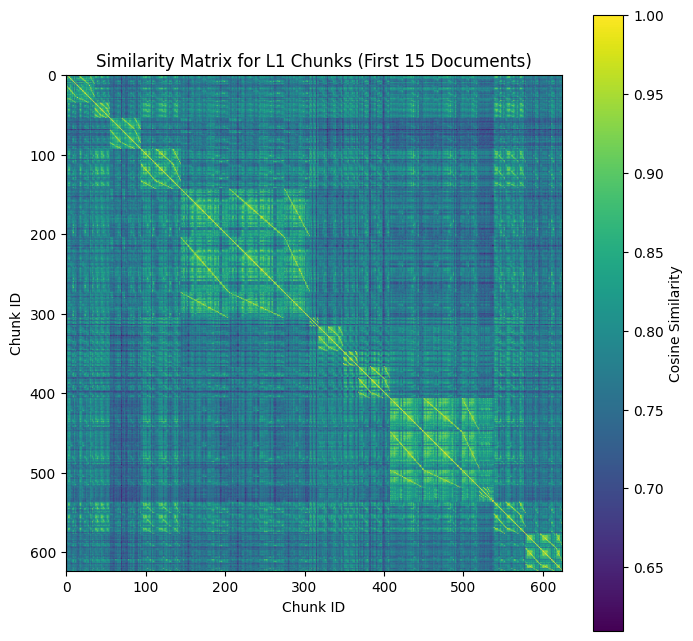


Similarity Statistics:
Mean similarity: 0.783
Max similarity: 1.000
Min similarity: 0.610

Top 5 Most Similar Chunk Pairs:


,chunk1,chunk2,doc1,doc2,similarity
86093,158,221,4,4,1.000001
21804,36,43,1,1,1.000000
21812,36,51,1,1,1.000000
25893,43,51,1,1,1.000000
32794,55,70,2,2,1.000000


In [ ]:
import matplotlib.pyplot as plt

# Display the similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Similarity Matrix for L1 Chunks (First 15 Documents)')
plt.xlabel('Chunk ID')
plt.ylabel('Chunk ID')
plt.show()

# Print some statistics about the similarities
print("\nSimilarity Statistics:")
print(f"Mean similarity: {similarity_matrix.mean():.3f}")
print(f"Max similarity: {similarity_matrix.max():.3f}")
print(f"Min similarity: {similarity_matrix.min():.3f}")

# Display the top 5 most similar chunk pairs
similarity_pairs = []
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        similarity_pairs.append({
            'chunk1': filtered_chunks.iloc[i]['chunk_id'],
            'chunk2': filtered_chunks.iloc[j]['chunk_id'],
            'doc1': filtered_chunks.iloc[i]['doc_id'],
            'doc2': filtered_chunks.iloc[j]['doc_id'],
            'similarity': similarity_matrix[i,j]
        })

similarity_pairs_df = pd.DataFrame(similarity_pairs)
top_5_similar = similarity_pairs_df.nlargest(5, 'similarity')
print("\nTop 5 Most Similar Chunk Pairs:")
display(top_5_similar)



Mean Similarity between Document 0 and Other Documents:


,doc_id,mean_similarity,doc_name
6,7,0.793490,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...
0,1,0.791369,ArconicRolledProductsCorp_20191217_10-12B_EX-2...
12,13,0.788092,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...
2,3,0.786207,ChinaRealEstateInformationCorp_20090929_F-1_EX...
8,9,0.782515,GluMobileInc_20070319_S-1A_EX-10.09_436630_EX-...
4,5,0.778101,DataCallTechnologies_20060918_SB-2A_EX-10.9_94...
3,4,0.774675,CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-1...
5,6,0.772140,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...
7,8,0.771907,GlobalTechnologiesGroupInc_20050928_10KSB_EX-1...
13,14,0.766383,GpaqAcquisitionHoldingsInc_20200123_S-4A_EX-10...


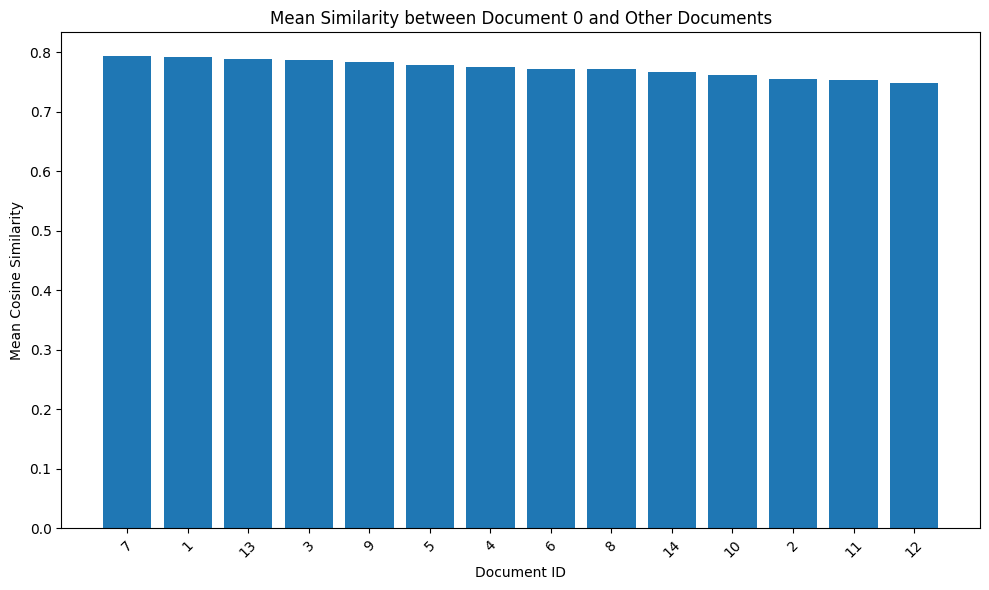

In [11]:
# Get all chunks from doc_id 0
doc0_chunks = filtered_chunks[filtered_chunks['doc_id'] == 0]

# Calculate mean similarity between doc0 and each other document
doc_similarities = []
for doc_id in filtered_chunks['doc_id'].unique():
    if doc_id == 0:
        continue
        
    # Get chunks from current document
    other_doc_chunks = filtered_chunks[filtered_chunks['doc_id'] == doc_id]
    
    # Calculate pairwise similarities between doc0 and other doc
    similarities = []
    for _, doc0_chunk in doc0_chunks.iterrows():
        for _, other_chunk in other_doc_chunks.iterrows():
            # Calculate cosine similarity between embeddings
            similarity = np.dot(doc0_chunk['embedding'], other_chunk['embedding']) / (
                np.linalg.norm(doc0_chunk['embedding']) * np.linalg.norm(other_chunk['embedding'])
            )
            similarities.append(similarity)
    
    # Calculate mean similarity for this document pair
    mean_similarity = np.mean(similarities)
    doc_similarities.append({
        'doc_id': doc_id,
        'mean_similarity': mean_similarity,
        'doc_name': other_doc_chunks.iloc[0]['doc_name']  # Get document name from first chunk
    })

# Create DataFrame and sort by similarity
doc_similarities_df = pd.DataFrame(doc_similarities)
doc_similarities_df = doc_similarities_df.sort_values('mean_similarity', ascending=False)

print("\nMean Similarity between Document 0 and Other Documents:")
display(doc_similarities_df)

# Visualize the similarities
plt.figure(figsize=(10, 6))
plt.bar(doc_similarities_df['doc_id'].astype(str), doc_similarities_df['mean_similarity'])
plt.title('Mean Similarity between Document 0 and Other Documents')
plt.xlabel('Document ID')
plt.ylabel('Mean Cosine Similarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Top 20 Most Similar Chunks to Document 0:


,doc0_chunk_id,other_chunk_id,other_doc_id,other_doc_name,similarity
2284,3,556,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.954320
2299,3,571,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.941386
1765,3,37,1,ArconicRolledProductsCorp_20191217_10-12B_EX-2...,0.932527
11104,18,556,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.928846
19913,33,545,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.927904
2268,3,540,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.927190
19929,33,561,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.926009
1772,3,44,1,ArconicRolledProductsCorp_20191217_10-12B_EX-2...,0.924120
11119,18,571,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.921729
2269,3,541,13,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,0.920530


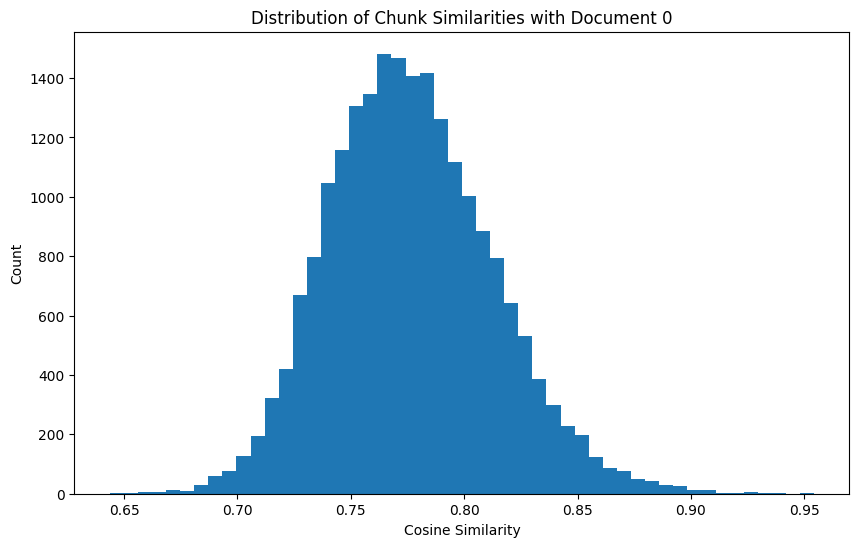

In [12]:
# Get all chunks from doc 0
doc0_chunks = filtered_chunks[filtered_chunks['doc_id'] == 0]

# Calculate similarities between doc0 chunks and all other chunks
chunk_similarities = []
for _, doc0_chunk in doc0_chunks.iterrows():
    for _, other_chunk in filtered_chunks.iterrows():
        # Skip if same document
        if other_chunk['doc_id'] == 0:
            continue
            
        # Calculate cosine similarity
        similarity = np.dot(doc0_chunk['embedding'], other_chunk['embedding']) / (
            np.linalg.norm(doc0_chunk['embedding']) * np.linalg.norm(other_chunk['embedding'])
        )
        
        chunk_similarities.append({
            'doc0_chunk_id': doc0_chunk['chunk_id'],
            'other_chunk_id': other_chunk['chunk_id'],
            'other_doc_id': other_chunk['doc_id'],
            'other_doc_name': other_chunk['doc_name'],
            'similarity': similarity
        })

# Create DataFrame and sort by similarity
chunk_similarities_df = pd.DataFrame(chunk_similarities)
chunk_similarities_df = chunk_similarities_df.sort_values('similarity', ascending=False)

# Display top 20 most similar chunks
print("\nTop 20 Most Similar Chunks to Document 0:")
display(chunk_similarities_df.head(20))

# Visualize the distribution of similarities
plt.figure(figsize=(10, 6))
plt.hist(chunk_similarities_df['similarity'], bins=50)
plt.title('Distribution of Chunk Similarities with Document 0')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()


In [14]:
def get_chunk_line_range(chunk_id, chunks_df, docs_df):
    """
    Given a chunk_id, returns the line range and content from the original document.

    Parameters:
    - chunk_id: int, the chunk ID to locate.
    - chunks_df: DataFrame, result of optimized_hybrid_chunking.
    - docs_df: DataFrame, original input documents DataFrame with 'id' and 'text' columns.

    Returns:
    - Dictionary with document name, chunk text, and line range.
    """
    # Find the chunk row
    chunk_row = chunks_df[chunks_df['chunk_id'] == chunk_id]
    if chunk_row.empty:
        return {"error": f"No chunk found with chunk_id {chunk_id}"}

    chunk_row = chunk_row.iloc[0]
    doc_id = chunk_row['doc_id']
    start_idx = chunk_row['start_idx']
    end_idx = chunk_row['end_idx']

    # Get the original document text
    doc_row = docs_df[docs_df['id'] == doc_id]
    if doc_row.empty:
        return {"error": f"No document found with id {doc_id}"}

    doc_text = doc_row.iloc[0]['text']
    doc_lines = doc_text.splitlines()

    # Determine line numbers based on character indices
    char_count = 0
    start_line = end_line = None

    for i, line in enumerate(doc_lines):
        line_length = len(line) + 1  # +1 for newline character
        if start_line is None and char_count + line_length > start_idx:
            start_line = i
        if end_line is None and char_count + line_length >= end_idx:
            end_line = i
            break
        char_count += line_length

    return {
        "document_name": chunk_row['doc_name'],
        "chunk_text": chunk_row['text'],
        "line_range": (start_line + 1, end_line + 1 if end_line is not None else len(doc_lines)),
        "total_lines_in_doc": len(doc_lines)
    }

In [35]:
result = get_chunk_line_range(
    chunk_id=42, chunks_df=hybrid_chunks_df, docs_df=docs_df)
with open('chunk_result.txt', 'w') as f:
    f.write(str(result))